# Chunk discontinuities in quantized block-based (non-overlapped) DWT-transformed audio signals

Let's research how quantization affects to the reconstruction of the chunks when they are DWT-transformed.

In [11]:
import sounddevice as sd
import pywt
import math
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pylab

## Capture an audio sequence

In [72]:
def plot(y, xlabel='', ylabel='', title='', marker='.'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.grid()
    ax.xaxis.set_label_text(xlabel)
    ax.yaxis.set_label_text(ylabel)
    x = np.linspace(0, len(y)-1, num=len(y))
    ax.plot(x, y, marker, markersize=1)
    plt.show(block=False)

In [103]:
fs = 44100
duration = 80000/44100  # seconds
signal = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype=np.int16)
print("Say something!")
while sd.wait():
    pass
print("done")
signal = signal.flatten()

Say something!
done


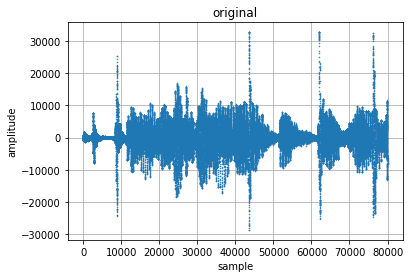

In [104]:
plot(signal, "sample", "amplitude", "original")

### Configuration of the experiment

In [105]:
levels = 6           # Number of levels of the DWT
#filters_name = "db5"
#filters_name = "haar"
#filters_name = "db11"
#filters_name = "db20"
#filters_name = "bior2.2"
#filters_name = "bior3.5"
filters_name = "bior3.7"
#filters_name = "rbio2.2"
wavelet = pywt.Wavelet(filters_name)
signal_mode_extension = "per"
quantization_step = 2048
chunk_size = 1024
chunk_number = 10

## Dead-zone quantizer

In [106]:
def deadzone_quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int)
    return k

def deadzone_dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

## Extract 3 consecutive chunks from the audio sequence

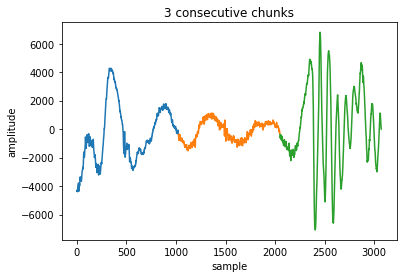

In [129]:
left_chunk = signal[chunk_size * (chunk_number - 1) : chunk_size * chunk_number]
center_chunk = signal[chunk_size * chunk_number : chunk_size * (chunk_number + 1)]
right_chunk = signal[chunk_size * (chunk_number + 1) : chunk_size * (chunk_number + 2)]
chunks = np.concatenate([left_chunk, center_chunk, right_chunk])
#pylab.xlim([len(left_chunk) - number_of_overlapped_samples, len(left_chunk)*2 + number_of_overlapped_samples])
pylab.plot(np.linspace(0, len(left_chunk)-1, len(left_chunk)), left_chunk)
pylab.plot(np.linspace(len(left_chunk), len(left_chunk) + len(center_chunk) - 1, len(center_chunk)), center_chunk)
pylab.plot(np.linspace(len(left_chunk) + len(center_chunk), len(left_chunk) + len(center_chunk) + len(right_chunk) - 1, len(right_chunk)), right_chunk)
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("3 consecutive chunks")
pylab.savefig("3_chunks.svg")
pylab.show()

In [108]:
number_of_overlapped_samples = 1 << math.ceil(math.log((wavelet.dec_len+0) * levels) / math.log(2))
#number_of_overlapped_samples = 8
number_of_overlapped_samples

128

## Algorithm 0: Quantization of the chunks in the DWT domain

* For each chunk:
    * Transform.
    * Quantize.
    * Dequantize.
    * Detransform.

In [109]:
def transform_and_quantize(chunk):
    decomposition = pywt.wavedec(chunk, wavelet=wavelet, level=levels, mode=signal_mode_extension)
    quantized_decomposition = []
    for subband in decomposition:
        quantized_subband = deadzone_quantizer(subband, quantization_step)
        quantized_decomposition.append(quantized_subband)
    return quantized_decomposition
    
def dequantize_and_detransform(decomposition):
    dequantized_decomposition = []
    for subband in decomposition:
        dequantized_subband = deadzone_dequantizer(subband, quantization_step)
        dequantized_decomposition.append(dequantized_subband)
    chunk = pywt.waverec(dequantized_decomposition, wavelet=wavelet, mode=signal_mode_extension)
    return chunk

def reconstruct_chunk(chunk):
    quantized_subbands = transform_and_quantize(chunk)
    reconstructed_chunk = dequantize_and_detransform(quantized_subbands)
    return reconstructed_chunk

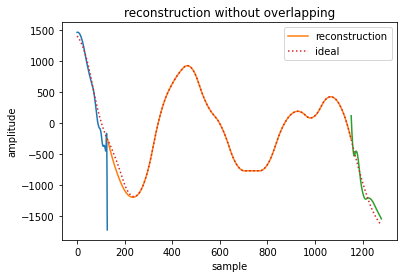

In [130]:
reconstructed_left_chunk = reconstruct_chunk(left_chunk)[-number_of_overlapped_samples:]
reconstructed_center_chunk = reconstruct_chunk(center_chunk)
reconstructed_right_chunk = reconstruct_chunk(right_chunk)[:number_of_overlapped_samples]
ideal_chunks_reconstruction = reconstruct_chunk(chunks)
_ideal_chunks_reconstruction = ideal_chunks_reconstruction[(-number_of_overlapped_samples  + len(left_chunk)):-(-number_of_overlapped_samples+len(left_chunk))]

pylab.plot(np.linspace(0, len(reconstructed_left_chunk)-1, len(reconstructed_left_chunk)),
           reconstructed_left_chunk)
pylab.plot(np.linspace(len(reconstructed_left_chunk),
                       len(reconstructed_left_chunk) + len(reconstructed_center_chunk) - 1,
                       len(reconstructed_center_chunk)),
           reconstructed_center_chunk, label="reconstruction")
pylab.plot(np.linspace(len(reconstructed_left_chunk) + len(reconstructed_center_chunk),
                       len(reconstructed_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_right_chunk) - 1,
                       len(reconstructed_right_chunk)), reconstructed_right_chunk)
pylab.plot(np.linspace(0, len(_ideal_chunks_reconstruction)-1,
                       len(_ideal_chunks_reconstruction)),
           _ideal_chunks_reconstruction, linestyle='dotted', label="ideal")
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstruction without overlapping")
pylab.legend(loc='upper right')
#pylab.savefig("without.svg")
pylab.show()

Signal discontinuities usually happen between adjacent chunks :-/

## Algorithm 1: Overlap the chunks and transmit overlapped areas

* For each chunk:
    * Build an extended chunk using neighbor samples.
    * Transform the extended chunk.
    * Quantize the extended decomposition.
    * Dequantize the extended decomposition.
    * Detransform the extended decomposition.
    * Use only the non-overlaped samples of the reconstructed extended chunk.
    
```
+------------+--------------+-------------+
| left_chunk | center_chunk | right_chunk |
+------------+--------------+-------------+
           OO OOOOOOOOOOOOOO OO <--- extended center_chunk
           ^^                ^^
           ||                ||
           ++----------------++----- overlaped samples (for center_chunk)
```

Notice that the extended decomposition (in general) is going to be longer than the non-extended one, and therefore, it  will need more bits to be represented. However, notice also that we are compressing the decomposition and therefore, the memory increment should be small. Anyway, to determine which stragegy is the best one, ask to the RD curves!

### Creation of the extended chunk

number of samples overlapped with left_chunk = 128
number of samples in the center_chunk = 1024
number of samples overlapped with right_chunk = 128
length of the extended center_chunk = 1280


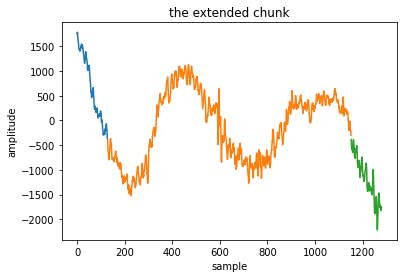

In [131]:
last_samples_left_chunk = left_chunk[chunk_size - number_of_overlapped_samples :]
first_samples_right_chunk = right_chunk[: number_of_overlapped_samples]
extended_chunk = np.concatenate([last_samples_left_chunk, center_chunk, first_samples_right_chunk])
print("number of samples overlapped with left_chunk =", len(last_samples_left_chunk))
print("number of samples in the center_chunk =", len(center_chunk))
print("number of samples overlapped with right_chunk =", len(first_samples_right_chunk))
print("length of the extended center_chunk =", len(extended_chunk))
pylab.plot(np.linspace(0,
                       len(last_samples_left_chunk)-1,
                       len(last_samples_left_chunk)),
           last_samples_left_chunk)
pylab.plot(np.linspace(len(last_samples_left_chunk),
                       len(last_samples_left_chunk) + len(center_chunk) - 1,
                       len(center_chunk)),
           center_chunk)
pylab.plot(np.linspace(len(last_samples_left_chunk) + len(center_chunk),
                       len(last_samples_left_chunk) + len(center_chunk) + len(first_samples_right_chunk) - 1,
                       len(first_samples_right_chunk)),
           first_samples_right_chunk)
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("the extended chunk")
#pylab.savefig("extended.svg")
pylab.show()

### Transform, quantize, dequantize and detransform the extended chunk

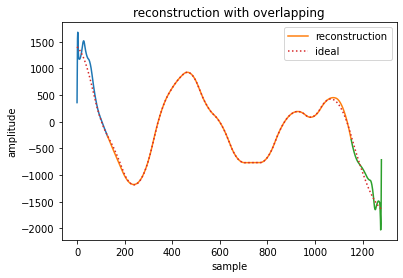

In [132]:
reconstructed_extended_chunk = reconstruct_chunk(extended_chunk)
reconstructed_last_samples_left_chunk = reconstructed_extended_chunk[0:number_of_overlapped_samples]
reconstructed_center_chunk = reconstructed_extended_chunk[number_of_overlapped_samples:chunk_size + number_of_overlapped_samples]
reconstructed_first_samples_right_chunk = reconstructed_extended_chunk[chunk_size + number_of_overlapped_samples:]
#ideal_reconstruction = ideal_chunks_reconstruction[
#    chunk_size - number_of_overlapped_samples:
#    2*chunk_size + number_of_overlapped_samples]

pylab.plot(np.linspace(0,
                       len(reconstructed_last_samples_left_chunk)-1,
                       len(reconstructed_last_samples_left_chunk)),
           reconstructed_last_samples_left_chunk)
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) - 1,
                       len(reconstructed_center_chunk)),
           reconstructed_center_chunk, label="reconstruction")
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_first_samples_right_chunk) - 1,
                       len(reconstructed_first_samples_right_chunk)),
           reconstructed_first_samples_right_chunk)
pylab.plot(np.linspace(0,
                       len(_ideal_chunks_reconstruction)-1,
                       len(_ideal_chunks_reconstruction)),
           _ideal_chunks_reconstruction, linestyle='dotted', label="ideal")
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstruction with overlapping")
#pylab.legend(loc='upper right')
pylab.legend()
#pylab.savefig("reconstructed.svg")
pylab.show()

Now, center_chunk is reconstructed without discontinuities :-)

## Algorithm 2: Overlap the chunks but transmit only central coeffs

16


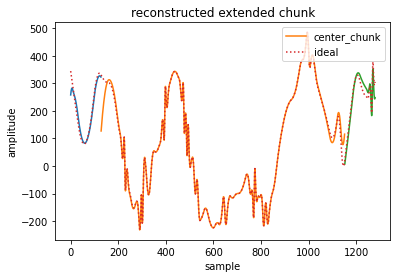

In [34]:
quantized_subbands = transform_and_quantize(extended_chunk)
foa = number_of_overlapped_samples#//2
#_foa = foa
_quantized_subbands = [None]*len(quantized_subbands)
for i in range(len(quantized_subbands)-1, 0, -1):
    foa >>= 1
    _quantized_subbands[i] = quantized_subbands[i][foa:len(quantized_subbands[i])-foa].copy()
    #print(len(_quantized_subbands[i]))
    #print(i)
_quantized_subbands[0] = quantized_subbands[0][foa:len(quantized_subbands[0])-foa].copy()
print(len(_quantized_subbands[i]))

reconstructed_center_chunk = dequantize_and_detransform(_quantized_subbands)#[_foa:-_foa]
#reconstructed_chunk = dequantize_and_detransform(quantization_indexes)

pylab.plot(np.linspace(0,
                       len(reconstructed_last_samples_left_chunk)-1,
                       len(reconstructed_last_samples_left_chunk)),
           reconstructed_last_samples_left_chunk)
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) - 1,
                       len(reconstructed_center_chunk)),
           reconstructed_center_chunk, label="center_chunk")
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_first_samples_right_chunk) - 1,
                       len(reconstructed_first_samples_right_chunk)),
           reconstructed_first_samples_right_chunk)
pylab.plot(np.linspace(0,
                       len(_ideal_chunks_reconstruction)-1,
                       len(_ideal_chunks_reconstruction)),
           _ideal_chunks_reconstruction, linestyle='dotted', label="ideal")
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstructed extended chunk")
pylab.legend(loc='upper right')
pylab.show()

## Algorithm 3: Overlap right-shifted chunks

In [35]:
chunk_0 = np.concatenate([left_chunk[number_of_overlapped_samples:], center_chunk[:number_of_overlapped_samples]])
chunk_0_quantized_subbands = transform_and_quantize(chunk_0)
reconstructed_chunk_0 = dequantize_and_detransform(chunk_0_quantized_subbands)[]

chunk_1 = np.concatenate([center_chunk[number_of_overlapped_samples:], right_chunk[:number_of_overlapped_samples]])
chunk_1_quantized_subbands = transform_and_quantize(chunk_1)
reconstructed_chunk_1 = dequantize_and_detransform(chunk_1_quantized_subbands)

pylab.plot(np.linspace(0, len(chunk_0)-1, len(chunk_0)), reconstructed_chunk_0)
pylab.plot(np.linspace(len(chunk_0), len(chunk_0)+len(chunk_1)-1, len(chunk_1)), reconstructed_chunk_1)
pylab.plot(np.linspace(len(ideal_chunks_reconstruction), len(ideal_chunks_reconstruction)+len(ideal_chunks_reconstruction)-1, len(ideal_chunks_reconstruction)), ideal_chunks_reconstruction)
pylab.show()

SyntaxError: invalid syntax (<ipython-input-35-b6195a1c2eb1>, line 3)

## Transform using per, detransform using sym

In [36]:
def transform_and_quantize(chunk):
    decomposition = pywt.wavedec(chunk, wavelet=wavelet, level=levels, mode="per")
    quantized_decomposition = []
    for subband in decomposition:
        quantized_subband = deadzone_quantizer(subband, quantization_step)
        quantized_decomposition.append(quantized_subband)
    return quantized_decomposition
    
def dequantize_and_detransform(decomposition):
    dequantized_decomposition = []
    for subband in decomposition:
        dequantized_subband = deadzone_dequantizer(subband, quantization_step)
        dequantized_decomposition.append(dequantized_subband)
    chunk = pywt.waverec(dequantized_decomposition, wavelet=wavelet, mode="sym")
    return chunk

def reconstruct_chunk(chunk):
    quantization_indexes = transform_and_quantize(chunk)
    
    reconstructed_chunk = dequantize_and_detransform(quantization_indexes)
    return reconstructed_chunk

### Transform, quantize, dequantize and detransform the extended chunk

In [37]:
decomposition = pywt.wavedec(extended_chunk, wavelet=wavelet, level=levels, mode="per")
print(pywt.coeffs_to_array(decomposition))

(array([ 1.21318380e+03,  1.68269271e+03,  3.12906834e+03, ...,
       -2.47487373e+00, -2.29809704e+00, -1.32582521e+01]), [(slice(None, 20, None),), {'d': (slice(20, 40, None),)}, {'d': (slice(40, 80, None),)}, {'d': (slice(80, 160, None),)}, {'d': (slice(160, 320, None),)}, {'d': (slice(320, 640, None),)}, {'d': (slice(640, 1280, None),)}])


In [38]:
decomposition = pywt.wavedec(center_chunk, wavelet=wavelet, level=levels, mode="sym")
print(pywt.coeffs_to_array(decomposition))

(array([2602.35706165, 2713.64715261, 2642.3629142 , ...,  -17.14733944,
         25.10229073,    7.24784451]), [(slice(None, 30, None),), {'d': (slice(30, 60, None),)}, {'d': (slice(60, 106, None),)}, {'d': (slice(106, 184, None),)}, {'d': (slice(184, 325, None),)}, {'d': (slice(325, 592, None),)}, {'d': (slice(592, 1111, None),)}])


In [39]:
reconstructed_extended_chunk = reconstruct_chunk(extended_chunk)
reconstructed_last_samples_left_chunk = reconstructed_extended_chunk[0:number_of_overlapped_samples]
reconstructed_center_chunk = reconstructed_extended_chunk[number_of_overlapped_samples:chunk_size + number_of_overlapped_samples]
reconstructed_first_samples_right_chunk = reconstructed_extended_chunk[chunk_size + number_of_overlapped_samples:]
ideal_reconstruction = ideal_chunks_reconstruction[
    chunk_size - number_of_overlapped_samples:
    2*chunk_size + number_of_overlapped_samples]

pylab.plot(np.linspace(0,
                       len(reconstructed_last_samples_left_chunk)-1,
                       len(reconstructed_last_samples_left_chunk)),
           reconstructed_last_samples_left_chunk)
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) - 1,
                       len(reconstructed_center_chunk)),
           reconstructed_center_chunk, label="center_chunk")
pylab.plot(np.linspace(len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk),
                       len(reconstructed_last_samples_left_chunk) + len(reconstructed_center_chunk) + len(reconstructed_first_samples_right_chunk) - 1,
                       len(reconstructed_first_samples_right_chunk)),
           reconstructed_first_samples_right_chunk)
pylab.plot(np.linspace(0,
                       len(ideal_reconstruction)-1,
                       len(ideal_reconstruction)),
           ideal_reconstruction, linestyle='dotted', label="ideal")
pylab.xlabel("sample")
pylab.ylabel("amplitude")
pylab.title("reconstructed extended chunk")
#pylab.legend(loc='upper right')
pylab.legend()
#pylab.savefig("reconstructed.svg")
pylab.show()

ValueError: coefficient shape mismatch